In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '../samples')
from paf_loader import Loader, load_confidence_map_and_paf
import numpy as np
import cv2
from cselect import color as cs
from time import time
import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.evaluation import pcp
from mvpose import settings
from os.path import isfile, join

data_root = Settings['data_root']

params = settings.get_settings(scale_to_mm=1000,
                               min_nbr_joints=5,
                               max_epi_distance=25,
                               ms_radius=30,
                               ms_between_distance=100,
                               hm_detection_threshold=0.05,
                               gp_max_radius=150
                              )
# ==================================
# params = settings.get_settings(scale_to_mm=1000,
#                                min_nbr_joints=5,
#                                max_epi_distance=25,
#                               hm_detection_threshold=0.05,
#                               min_joint_distance=20,
#                               ms_radius=60,
#                               ms_between_distance=60)

import mvpose.data.skeleton_augmentation as ska
model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, params.scale_to_mm)

# ----------------------------------
# ==================================
# default
seq1_zipname = 'player2sequence1.zip'
seq1_dir = 'Sequence 1'
# ----------------------------------


# seq1_zipname = 'player2sequence2.zip'
# seq1_dir = 'Sequence 2'
# ==================================
# ----------------------------------


# ====================================================
# Extractor Functions
# ====================================================
def extract_best(pos3d, Humans, alpha):
    """
        Extracts the best fitting human for the calculation
    """
    larms = 0
    uarms = 0
    ulegs = 0
    llegs = 0
    all_parts = 0
    
    for h in Humans:
        r = pcp.evaluate(pos3d, Humans[0], alpha)
        if all_parts < r.all_parts:
            larms = r.lower_arms
            uarms = r.upper_arms
            ulegs = r.upper_legs
            llegs = r.lower_legs
    
    return {
        "larms": larms,
        "uarms": uarms,
        "ulegs": ulegs,
        "llegs": llegs
    }


# OBJECTIVE_VALUES = []
# CENTERS_3D = []
# LIMBS = []
# PEAKS_3D = []
# PEAKS_2D = []

# MISSED_DETECTIONS = 0


def apply(frame, alpha, loader):
    """
    """
    #global OBJECTIVE_VALUES, CENTERS_3D, MISSED_DETECTIONS
    global seq1_zipname
    global seq1_zip
    global EXP_NBR
    Im, Calib, pos2d, pos3d = kth.get(
        data_root, seq1_zipname, seq1_dir, frame, player=2)
    heatmaps, pafs = loader.load_confidence_map_and_paf(
        'kth' + seq1_zipname[0:-4], Im, frame, dir=Settings['tmp'])
    
    
#     fname = join('/tmp', EXP_NBR + "_frame" + str(frame) + '.npy')
#     if isfile(fname):
#         detections = np.load(fname)
#     else:
    detections = pose.estimate(Calib, heatmaps, pafs, 
                           settings=params)

    detections = gen.apply(detections)
    
    if len(detections) == 0:
        return {
            "larms": 0,
            "uarms": 0,
            "ulegs": 0,
            "llegs": 0
        }
        
    
    Humans = kth.transform3d_from_mscoco(detections)
    result1 = extract_best(pos3d, Humans, alpha)

        # ---------------------------------


    #     detections = gen.apply(detections)
    #     Humans = kth.transform3d_from_mscoco(detections)
    #     result2 = extract_best(pos3d, Humans, alpha)

    del Im
    del Calib
    del pos2d
    del pos3d
    del heatmaps
    del pafs
    del detections
    del Humans

    return result1
    
#     else:
#         MISSED_DETECTIONS += 1
#         centers3d = []
#         obj_value = []
#         limbs3d = []
#         peaks3d = []
#         peaks2d = []
        
#         CENTERS_3D.append(centers3d)
#         OBJECTIVE_VALUES.append(obj_value)
#         LIMBS.append(limbs3d)
#         PEAKS_3D.append(peaks3d)
#         PEAKS_2D.append(peaks2d)
        
#         return {
#             "larms": 0,
#             "uarms": 0,
#             "ulegs": 0,
#             "llegs": 0
#         }
        
#         np.save(fname, detections)
    
    #return result1, result2
    #return result1

/home/tanke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def run_experiment():
    
    loader = Loader(with_gpu=True)

    alpha = 0.5

    larms = []
    uarms = []
    llegs = []
    ulegs = []

    # 0 .. 214
    for frame in range(0, 214):
        _start = time()
        result = apply(frame, alpha, loader)
        larms.append(result['larms'])
        uarms.append(result['uarms'])
        llegs.append(result['llegs'])
        ulegs.append(result['ulegs'])

        _end = time()
        print('frame ' + str(frame) + ', elapsed', _end - _start)
    
    return larms, uarms, llegs, ulegs

larms, uarms, llegs, ulegs = run_experiment()

frame 0, elapsed 4.749200820922852
frame 1, elapsed 2.5439720153808594
frame 2, elapsed 2.604501724243164
frame 3, elapsed 2.5499954223632812
frame 4, elapsed 2.673738479614258
frame 5, elapsed 2.570136308670044
frame 6, elapsed 2.493133783340454
frame 7, elapsed 2.535149097442627
frame 8, elapsed 2.485175848007202
frame 9, elapsed 3.042076826095581
frame 10, elapsed 2.5424387454986572
frame 11, elapsed 2.407637596130371
frame 12, elapsed 2.5467581748962402
frame 13, elapsed 2.5147910118103027
frame 14, elapsed 2.5786526203155518
frame 15, elapsed 2.388043165206909
frame 16, elapsed 2.5859944820404053
frame 17, elapsed 2.4274306297302246
frame 18, elapsed 2.449028491973877
frame 19, elapsed 2.377359628677368
frame 20, elapsed 2.3719120025634766
frame 21, elapsed 2.460024356842041
frame 22, elapsed 2.3899660110473633
frame 23, elapsed 2.4220938682556152
frame 24, elapsed 2.3851757049560547
frame 25, elapsed 2.383619546890259
frame 26, elapsed 2.49354887008667
frame 27, elapsed 2.4435107

## Find best calib object

### A
* upper arms:	 0.9602803738317757
* lower arms:	 0.9135514018691588
* upper legs:	 0.9462616822429907
* lower legs:	 0.9088785046728972
* avg:		 0.9322429906542057

In [3]:
print("upper arms:\t", np.mean(uarms))
print("lower arms:\t", np.mean(larms))
print("upper legs:\t", np.mean(ulegs))
print("lower legs:\t", np.mean(llegs))
print('avg:\t\t', np.mean([
    np.mean(uarms), np.mean(larms), np.mean(ulegs), np.mean(llegs)
]))

upper arms:	 0.955607476635514
lower arms:	 0.8878504672897196
upper legs:	 0.9579439252336449
lower legs:	 0.9182242990654206
avg:		 0.9299065420560748


In [4]:
# ==================================
# params = settings.get_settings(scale_to_mm=1000,
#                                min_nbr_joints=5,
#                                max_epi_distance=25,
#                                ms_radius=30,
#                                ms_between_distance=100,
#                                hm_detection_threshold=0.05,
#                                gp_max_radius=150
#                               )
# WITH PC
# upper arms:	 0.955607476635514
# lower arms:	 0.8878504672897196
# upper legs:	 0.9579439252336449
# lower legs:	 0.9182242990654206
# avg:		 0.9299065420560748

# ==================================
# params = settings.get_settings(scale_to_mm=1000,
#                                min_nbr_joints=5,
#                                max_epi_distance=25,
#                                ms_radius=90,
#                                ms_between_distance=120,
#                                hm_detection_threshold=0.05,
#                                gp_max_radius=150
#                               )
# Without PC
# upper arms:	 0.9462616822429907
# lower arms:	 0.8481308411214953
# upper legs:	 0.9579439252336449
# lower legs:	 0.9135514018691588
# avg:		 0.9164719626168224

# WITH PC
# upper arms:	 0.9532710280373832
# lower arms:	 0.8785046728971962
# upper legs:	 0.9579439252336449
# lower legs:	 0.9228971962616822
# avg:		 0.9281542056074766


# ==================================
# params = settings.get_settings(scale_to_mm=1000,
#                                min_nbr_joints=5,
#                                max_epi_distance=25)
# upper arms:	 0.9532710280373832
# lower arms:	 0.8411214953271028
# upper legs:	 0.9439252336448598
# lower legs:	 0.9042056074766355
# avg:		 0.9106308411214953

# ==================================
# params = settings.get_settings(scale_to_mm=1000,
#                                min_nbr_joints=5,
#                                max_epi_distance=25,
#                               hm_detection_threshold=0.05,
#                               min_joint_distance=20,
#                               ms_radius=60,
#                               ms_between_distance=60)
# upper arms:	 0.9649532710280374
# lower arms:	 0.852803738317757
# upper legs:	 0.9252336448598131
# lower legs:	 0.8925233644859814
# avg:		 0.9088785046728973

# ==================================
#params = settings.get_settings(scale_to_mm=1000)
# OHNE PC
# upper arms:	 0.8154205607476636
# lower arms:	 0.6612149532710281
# upper legs:	 0.7757009345794392
# lower legs:	 0.6565420560747663
# avg:		 0.7272196261682242


# ==================================
# params = settings.get_settings(scale_to_mm=1000,
#                               hm_detection_threshold=0.05,
#                               min_joint_distance=20,
#                               ms_radius=60,
#                               ms_between_distance=60)
# upper arms:	 0.8294392523364486
# lower arms:	 0.6915887850467289
# upper legs:	 0.7967289719626168
# lower legs:	 0.6869158878504673
# avg:		 0.7511682242990654

# ==================================
# params = settings.get_settings(scale_to_mm=1000,
#                                min_nbr_joints=5,
#                                max_epi_distance=25,
#                               hm_detection_threshold=0.05,
#                               min_joint_distance=20,
#                               ms_radius=60,
#                               ms_between_distance=60)

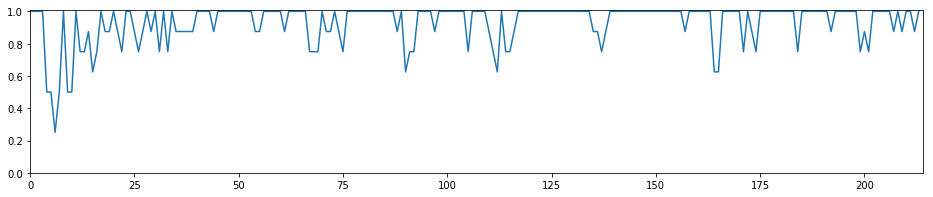

In [5]:
fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(111)
x = range(0, len(uarms))

# ax.plot(x, uarms, label='uarms')
# ax.plot(x, larms, label='larms')
# ax.plot(x, ulegs, label='ulegs')
# ax.plot(x, llegs, label='llegs')

mu = np.mean([uarms, larms, ulegs, llegs], axis=0)
ax.plot(x, mu)


#np.save('demo1_mu.npy', mu)
# mu_old = np.load('demo1_mu.npy')
# DIV = np.abs(mu - mu_old)
# print("div", np.sum(DIV))


ax.set_xlim([0, 214])
ax.set_ylim([0, 1.01])

#plt.legend()
plt.show()

mu at frame 5: 0.5
step 1: elapsed 0.2614572048187256
step 2: elapsed 0.0039556026458740234
step 3: elapsed 0.03177499771118164
step 4: elapsed 0.32193446159362793
-------------------------------------------
Handle transitivity:
	Intra:		 3
	Intra(choice):	 4
	Inter:		 33
	Inter(choice):	 197
-------------------------------------------
	Time =  110  ms
	result: 0

	Total cost: 48.683013257419844

# valid points:		 33
# invalid points:	 17
step 5: elapsed 0.11280083656311035
(smart candidate selection) [
	Time =  1  ms
	result: 0

	Total cost: 3.8097917442598073
] (smart candidate selection)
step 6: elapsed 0.003607034683227539


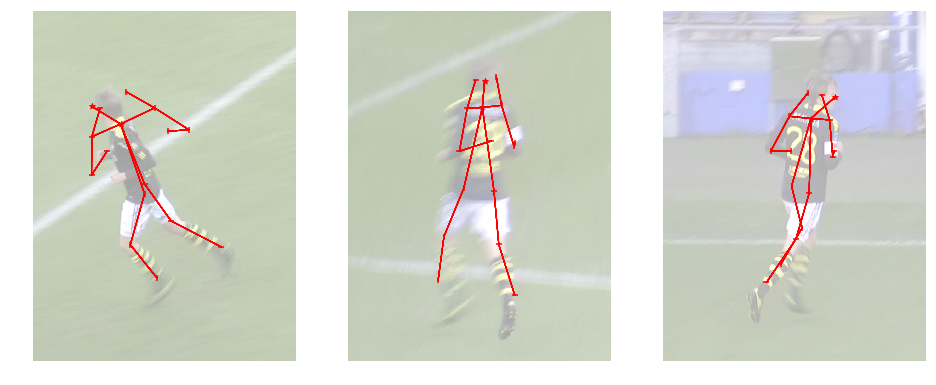

In [6]:
from mvpose.algorithm.candidate_selection import project_human_to_2d
from mvpose.plot.limbs import draw_mscoco_human

frame = 5
tmp = '/tmp'

print('mu at frame ' + str(frame) + ":", mu[frame])

Im, Calib, pos2d, pos3d = kth.get(
    data_root, seq1_zipname, seq1_dir, frame, player=2)
heatmaps, pafs = load_confidence_map_and_paf(
    'kth' + seq1_zipname[0:-4], Im, frame, dir=tmp)
_start = time()
Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                                  settings=params, debug=True)


Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
    
plt.show()

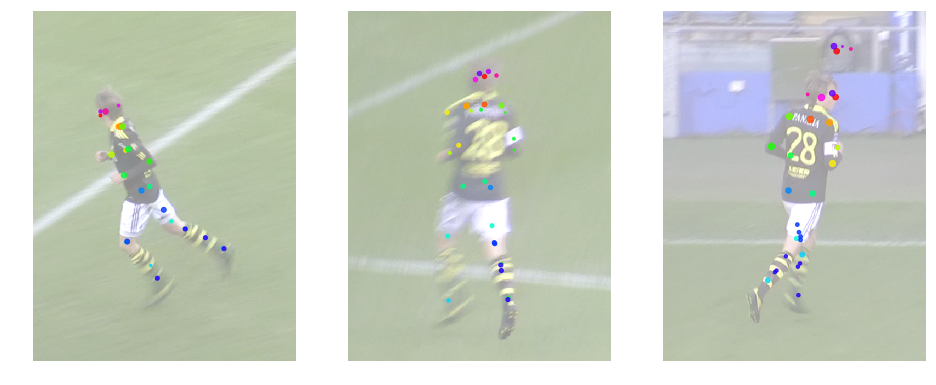

In [7]:
colors = cs.lincolor(20)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.set_xlim([0, 480])
    ax.set_ylim([640, 0])
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers2d_with_w = Debug.candidates2d.peaks2d[cid][jid]
        if len(centers2d_with_w) == 0:
            continue
        centers2d = centers2d_with_w[:,0:2].astype('float32')
        score = centers2d_with_w[:,2]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color=colors[jid], s=score*50, alpha=0.8)
    
plt.show()

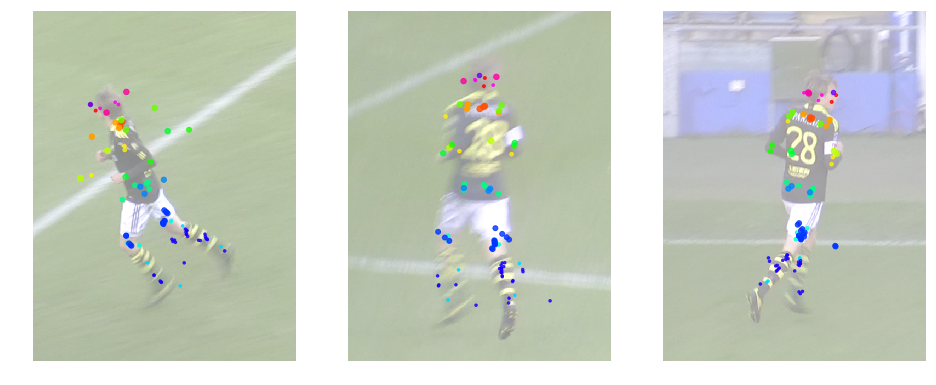

In [8]:
colors = cs.lincolor(20)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.triangulation.peaks3d_weighted[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color=colors[jid], s=score*50, alpha=0.8)
                #ax.text(x, y, str(jid))
    
plt.show()

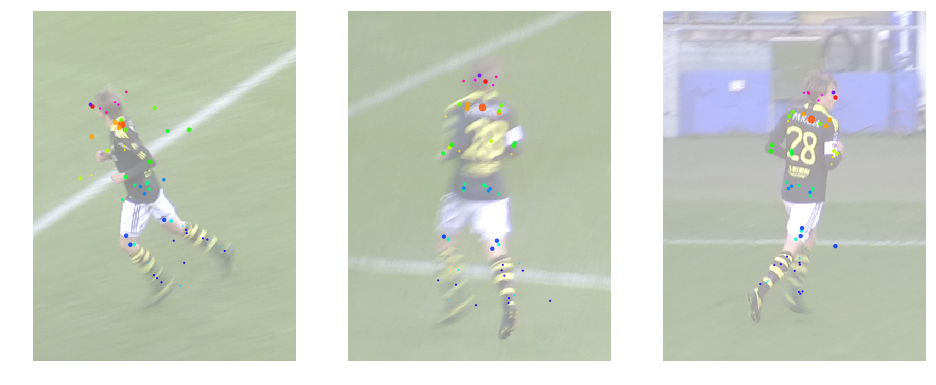

In [9]:
colors = cs.lincolor(20)/255

fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    cam = Calib[cid]
    
    for jid in range(Debug.candidates2d.n_joints):
        centers3d_with_w = Debug.meanshift.centers3d[jid]
        centers3d = centers3d_with_w[:,0:3].astype('float32')
        centers2d = cam.projectPoints(centers3d)
        score = centers3d_with_w[:,3]
        for p2d in centers2d:
            if p2d is not None:
                x, y = p2d
                ax.scatter(x, y, color=colors[jid], s=score*50, alpha=0.8)
                #ax.text(x, y, str(jid))
    
plt.show()

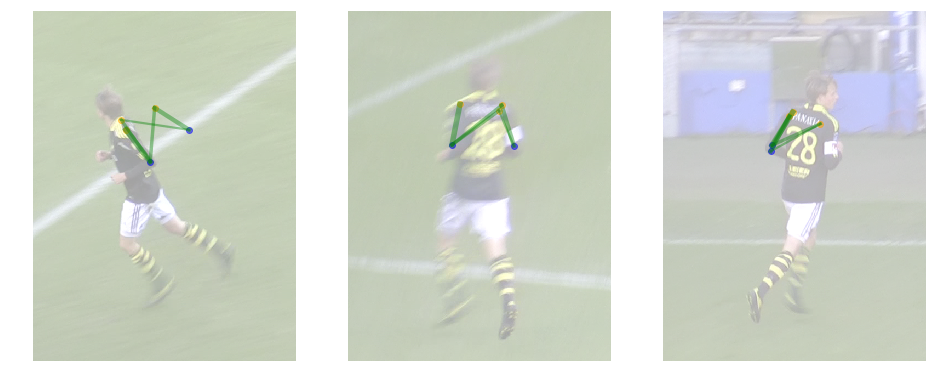

In [10]:
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ

# left leg = 11
# right arm = 2,3
# left arm = 4,5
LIMB_ID = 4
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Debug.limbs3d[LIMB_ID]
n,m = W.shape

candA = Debug.meanshift.centers3d[a][:,0:3]
candB = Debug.meanshift.centers3d[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))


for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
    ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    sq_maskA = np.squeeze(maskA[0])
    sq_maskB = np.squeeze(maskB[0])
    if len(sq_maskA.shape) == 0:
        sq_maskA = np.expand_dims(sq_maskA, axis=0)
    if len(sq_maskB.shape) == 0:
        sq_maskB = np.expand_dims(sq_maskB, axis=0)
    
    for _a in sq_maskA:
        for _b in sq_maskB:
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*10, alpha=0.4)
            elif w > -99999:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*10, alpha=0.4)

plt.show()

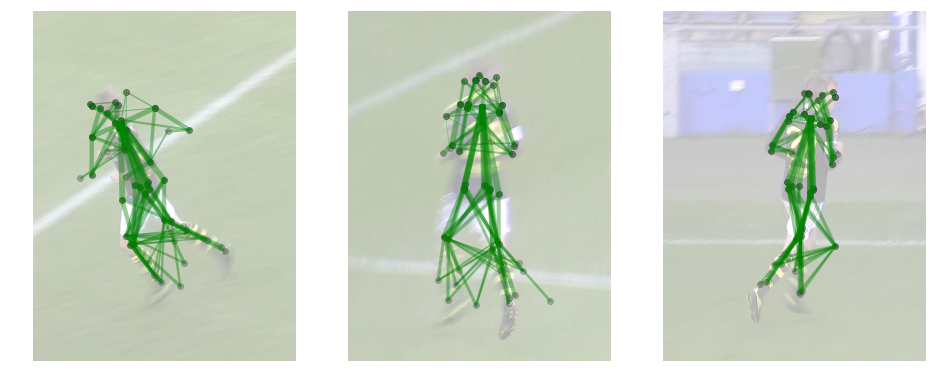

In [11]:
import numpy.linalg as la

fig = plt.figure(figsize=(16,12))

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    for lid, (a, b) in enumerate(DEFAULT_LIMB_SEQ):
        candA = Debug.meanshift.centers3d[a][:,0:3]
        candB = Debug.meanshift.centers3d[b][:,0:3]
        W = Debug.limbs3d[lid]
        n, m = W.shape
        assert n == len(candA) and m == len(candB)
        
        ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
        ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)

        ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='black', alpha=0.2)
        ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='black', alpha=0.2)
        
        sq_maskA = np.squeeze(maskA[0])
        sq_maskB = np.squeeze(maskB[0])
        if len(sq_maskA.shape) == 0:
            sq_maskA = np.expand_dims(sq_maskA, axis=0)
        if len(sq_maskB.shape) == 0:
            sq_maskB = np.expand_dims(sq_maskB, axis=0)
        
        min_length, max_length = params.sensible_limb_length[lid]
        
        for _a in sq_maskA:
            for _b in sq_maskB:
                p3dA = candA[_a]
                p3dB = candB[_b]
                distance = la.norm(p3dA - p3dB)
                lstype = '-'
                if distance < min_length or distance > max_length:
                    lstype = ':'
                    
                w = W[_a,_b]
                Ax,Ay = ptsA2d[_a]
                Bx,By = ptsB2d[_b]
                if w > 0:
                    ax.plot([Ax,Bx], [Ay,By], color='green', 
                            linestyle=lstype, linewidth=w*10, alpha=0.4)
                elif w > -99999:
                    ax.plot([Ax,Bx], [Ay,By], color='red', 
                            linestyle=lstype, linewidth=-w*10, alpha=0.4)

plt.show()